# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Camera Calibration

The code for this step is contained in the first code cell of the IPython notebook located in "./examples/example.ipynb" (or in lines # through # of the file called `some_file.py`).  
I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  
I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

(720, 1280, 3)


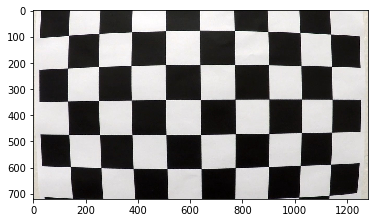

In [93]:
# Original chessboard image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('./camera_cal/calibration1.jpg')
print(image.shape)
plt.imshow(image)

# Some quick observations
# Image size is consistent
# However, number of intersection x and intersection y is not the same across all the images

In [94]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_chessboard_corners(fname, nx, ny):
    '''
    Convenience function for testing out chessboard detection
    Returns ret (boolean if result is available), corners coordinates and images
    '''
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    
    return ret, corners, img

def get_object_points(nx, ny):
    '''
    Function to get the object points needed to find the points on the chess board
    Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    '''
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    return objp
    
def get_obj_img_points(image_fname_list, nx, ny):
    '''
    Function to obtain the object and image point 
    '''
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Define a default object point
    objp = get_object_points(nx, ny) 
    
    # Step through the list and search for chessboard corners
    for fname in image_fname_list:
        # Find the chessboard corners
        ret, corners, mod_image = get_chessboard_corners(fname, nx, ny)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints
            

In [95]:
# Function testing - all are made to comments as they are only used for testing purposes

# Testing out the functions defined in the above cell
ret, corner, img = get_chessboard_corners('./camera_cal/calibration1.jpg', 9, 5)

True

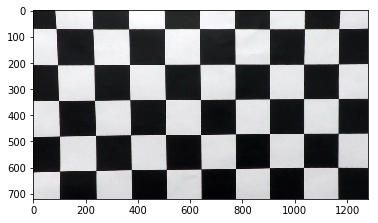

In [96]:
%matplotlib inline

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Get the object points and image points from a set of calibration images
objpoints, imgpoints = get_obj_img_points(images, 9, 6)

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistort
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Show image
plt.imshow(dst)

# Write the file out into the output folder
cv2.imwrite('./output_images/calibration1_undist.jpg',dst)

## Pipeline (single images)

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:




(720, 1280, 3)


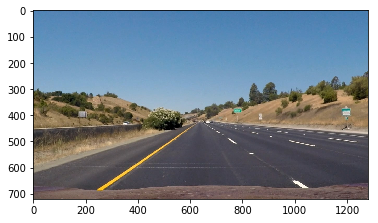

In [99]:
# Original chessboard image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Original Image
image = mpimg.imread('./test_images/straight_lines1.jpg')
print(image.shape)
plt.imshow(image)

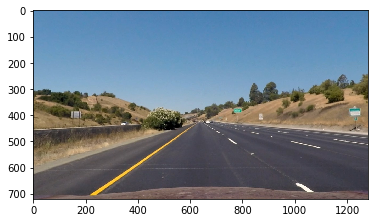

In [101]:
# Undistorted Image
dst = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(dst)

**Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.**

I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines # through # in `another_file.py`).  Here's an example of my output for this step.  (note: this is not actually from one of the test images)


In [119]:
# Define color threshold functions - Can choose to utilize which one of the color gradients work best

def rgb_threshold(image, filter=None, binary=False, lower_threshold=None, upper_threshold=None):
    '''
    Provide RGB image for processing. Allows one to select color filter and even color thresholding
    '''
    # Apply color filter
    if filter == 'r':
        image = image[:,:,0]
    if filter == 'g':
        image = image[:,:,1]
    if filter == 'b':
        image = image[:,:,2]
    
    # Allow user to select to binarize the image based on a threshold
    if binary:
        binary_image = np.zeros_like(image)
        binary_image[(image > lower_threshold) & (image <= upper_threshold)] = 255
        return binary_image
    else:
        return image

def hls_threshold(image, filter=None, binary=False, lower_threshold=None, upper_threshold=None):
    '''
    Provide RGB image for processing. Image will be converted to hls image. Allow one to select hls filter and hls
    thresholding
    '''
    # Convert to hls image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Apply color filter
    if filter == 'h':
        image = image[:,:,0]
    if filter == 'l':
        image = image[:,:,1]
    if filter == 's':
        image = image[:,:,2]
    
    # Allow user to select to binarize the image based on a threshold
    if binary:
        binary_image = np.zeros_like(image)
        binary_image[(image > lower_threshold) & (image <= upper_threshold)] = 255
        return binary_image
    else:
        return image

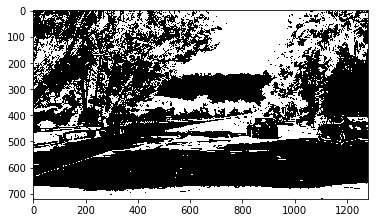

In [152]:
# Testing with just red filter doesn't work 
road_image = mpimg.imread('./test_images/test5.jpg')
filtered_road_image = rgb_threshold(road_image, 'r', True, 50, 140)
plt.imshow(filtered_road_image, cmap='gray')

**Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.**

The code for my perspective transform includes a function called `warper()`, which appears in lines 1 through 8 in the file `example.py` (output_images/examples/example.py) (or, for example, in the 3rd code cell of the IPython notebook).  The `warper()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

**Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?**

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

**Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.**

I did this in lines # through # in my code in `my_other_file.py`

**Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.**

I implemented this step in lines # through # in my code in `yet_another_file.py` in the function `map_lane()`.  Here is an example of my result on a test image:

![alt text][image6]


## Pipeline (video)

Here's a [link to my video result](./project_video.mp4)
TODO: Need to add the correct video link

## Discussion

1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  
